<a href="https://colab.research.google.com/github/jhk0429/Segmentation_project/blob/main/PSPNet/Inference_incep_psp_newdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = 'drive/MyDrive/Colab Notebooks/Inceptionv3_PSPNet_c/Inceptionv3_PSPNet'

In [3]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
from IPython.display import clear_output
import matplotlib.pyplot as plt

#import segmentation_models as sm

import numpy as np
from numpy import genfromtxt
import matplotlib
from matplotlib import pyplot
from matplotlib.image import imread

2.6.0


In [ ]:
"""
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
"""

"\n%tensorflow_version 2.x\nimport tensorflow as tf\ndevice_name = tf.test.gpu_device_name()\nif device_name != '/device:GPU:0':\n  raise SystemError('GPU device not found')\nprint('Found GPU at: {}'.format(device_name))\n"

In [4]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [29]:
import glob
import cv2
train_x = []
train_y = []

for img in glob.glob("images/test/*.bmp"):
    
    n = cv2.imread(img)
    n = tf.cast(n, tf.float32) / 255.0
    n = tf.image.resize(n, (480,480))
    #n = tf.expand_dims(n,-1)
    #n = tf.image.grayscale_to_rgb(n)
    train_x.append(n)

    dir = "/".join(img.split("/")[:-1]) + "/gt_mask/"
    file_name = img.split("/")[-1].split('.')[0]

    y = cv2.imread(dir+file_name+".png")
    #print(y)
    y = tf.cast(y, tf.float32) / 255.0
    y = tf.image.resize(y, (480,480))

    train_y.append(y)

test_x = tf.convert_to_tensor(train_x)
test_y = tf.convert_to_tensor(train_y)

print(test_x.shape)
print(test_y.shape)

(14, 480, 480, 3)
(14, 480, 480, 3)


In [30]:

def create_mask(pred_mask, num=0):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[num]

def show_predictions(test_mode=False, x=None,y=None, num=1):
  if test_mode:
    print("In testing Mode...")
    for i in range(num):
      pred_mask = model.predict(x, batch_size=1)
      display([x[i], y[i], create_mask(pred_mask, num=i)])

  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [37]:
mask = []

for yy in test_y:
  mask.append( tf.expand_dims(tf.argmax(yy, axis=-1),-1) )

mask = tf.convert_to_tensor(mask)
print(mask.shape)

(14, 480, 480, 1)


In [23]:
model = tf.keras.models.load_model(path)

In testing Mode...


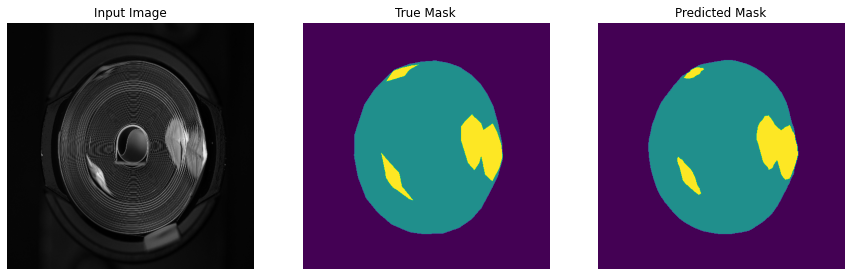

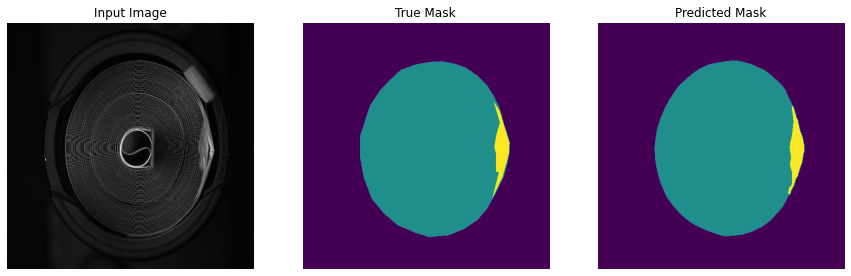

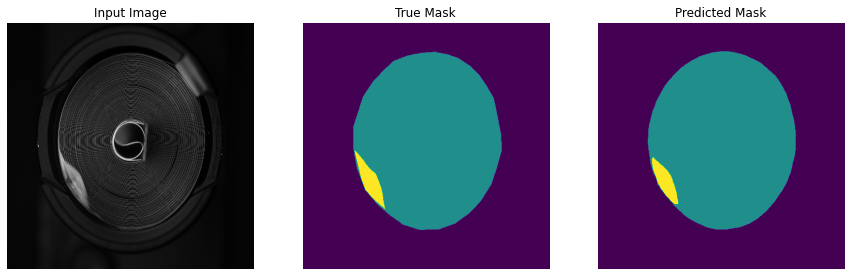

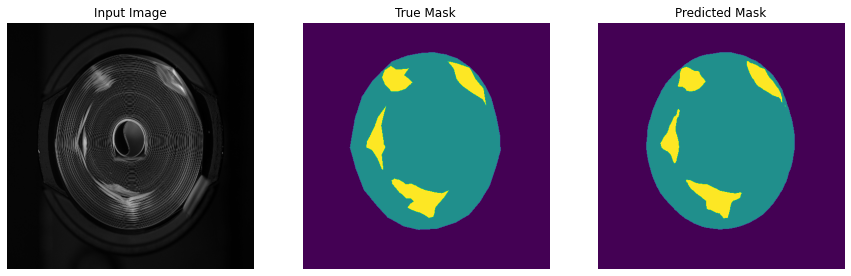

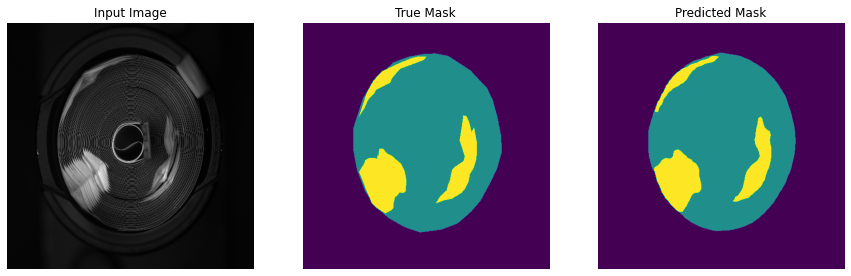

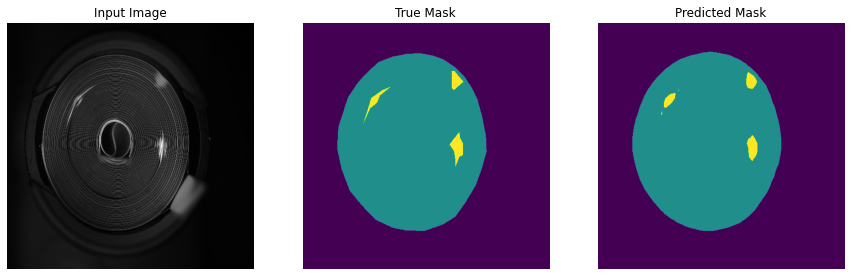

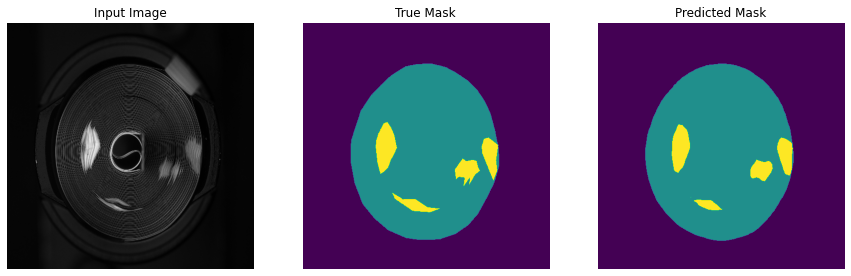

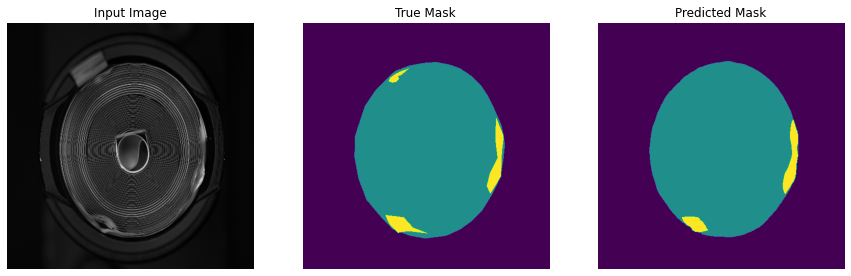

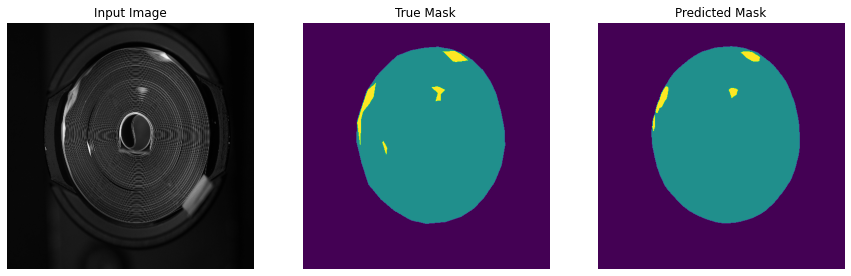

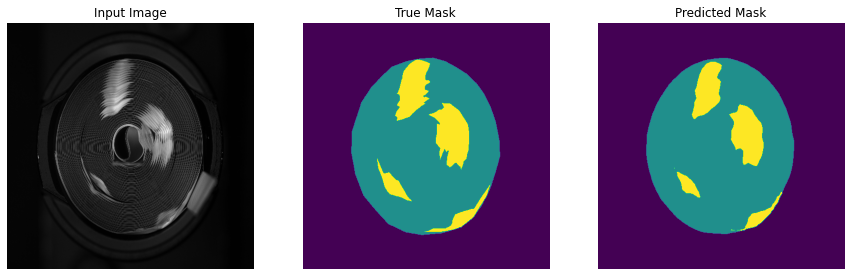

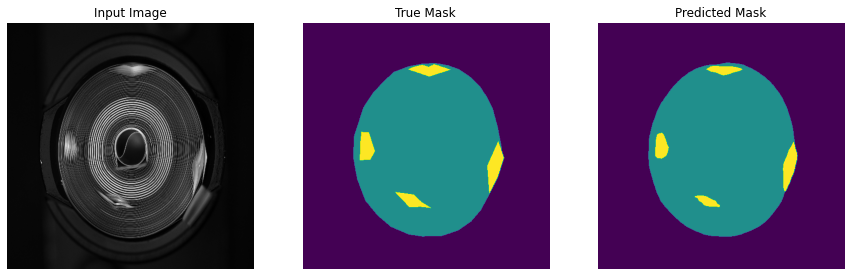

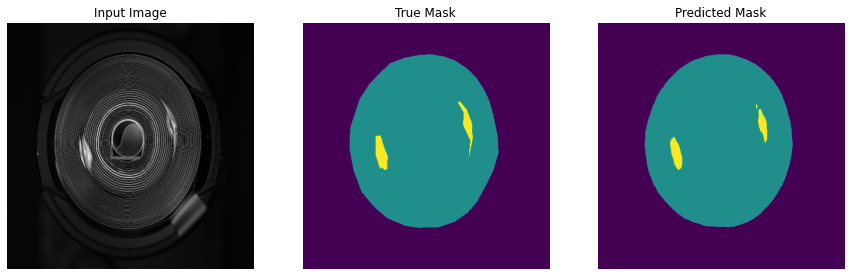

In [38]:
show_predictions(test_mode=True, x=test_x, y=mask, num=12)

In [13]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tqdm import tqdm
import time

In [14]:
# Load converted model and infer
model = tf.saved_model.load(path, tags=[trt.tag_constants.SERVING])
graph_func = model.signatures[trt.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
frozen_func = trt.convert_to_constants.convert_variables_to_constants_v2(graph_func)

In [18]:
#3669 test images
time_list = []
pred_mask = []
for image in tqdm(test_x):
  start = time.time()
  image = tf.expand_dims(image,0)
  pred_mask.append(frozen_func(image)) # 64, 144, 144, 3
  time_list.append(time.time()-start)

100%|██████████| 14/14 [00:00<00:00, 49.00it/s]


In [19]:
print("Average inference time is: ",np.mean(time_list) * 1000, "ms")

Average inference time is:  19.82637814113072 ms
